# CS440/ECE448 Spring 2023
# MP09: Perception

The first thing you need to do is to download this file: <a href="mp09.zip">mp09.zip</a>.  It has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp09_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `tests`: This directory contains visible test.

<!-- 
You will then need to download the CIFAR-10 dataset from the following link: <a href="https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz">CIFAR10 Dataset Download</a>. Please uncompress the zip file inside your mp09 folder. -->

The list of modules you will need to import/install:

* `torch`
* `numpy`
* `os`
* `torchvision`


You will not require a GPU for this MP.

This file (`mp09_notebook.ipynb`) will walk you through the full MPs with instructions and suggestion, and it is highly recommended that you follow this notebook.

### Goal

The objective of this assignment is to create a full end-to-end training and testing pipeline for a convolutional neural network (CNN) for the task of image classification on a modified version of the standard vision dataset `CIFAR10`. You will learn the concept of finetuning your model, in which you freeze your convolutional backbone and finetune newly initialized linear layer(s) for a specific task.

There are 8 target categories: `airplane (0), automobile (1), bird (2), deer (3), frog (4), horse (5), ship (6), truck (7)`. Given an image, your CNN will be expected to successfully classify an image into one of these categories. 

You will be using `PyTorch` for this MP. In `MP04`, you gained some familiarity with the PyTorch library and you will build upon this foundation in this MP by designing and implementing the whole pipeline from scratch.

You will need to consult the PyTorch documentation, to help you with implementation details. Please make sure you read the function definitions and descriptions in `submitted.py` carefully before completing them. 

### Table of Contents

1. <a href="#section1">Dataset</a>
1. <a href="#section1">Dataloader</a>
1. <a href="#section3">Model Finetuning</a>
1. <a href="#grade">Grade Your Homework</a>

<a id='section1'></a>
<a id='section2'></a>
## Dataset

In this section you will create a PyTorch Dataset based on the `torch.utils.data.Dataset` class. 

Some useful resources:

* <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR10 Specifications</a> for understanding the data format
* <a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">Datasets and Dataloaders</a> tutorial in PyTorch

It is highly recommended to read and understand these resources before diving into the code. Here is a short summary:

### CIFAR10 Specifications

The data folder contains 6 files, each of which is a pickled Python object: `data_batch_1`, `data_batch_2`, `data_batch_3`, `data_batch_4`, `data_batch_5`, `test_batch`. Each file contains roughly (this amount as we only observe 8 classes) 8000 samples from the dataset; the first 5 files correspond to our training set and the `test_batch` file corresponds to our test set. You will need to read all of these files and import the samples in the code. There are memory-efficient ways to do so, but simply reading all the samples from the files at once (according to train/test mode) will work fine for this assignment. Each file is a dictionary containing the data and the labels, which will be "visible" after unpickling. `data` is a numpy array of shape (num_samples, 3072) containing the pixel values (in range [0...255]) for the 32x32 image. The pixel values are stored in a specific order (R values, G values and then B values in row-major order) described in detail in the provided link above. `labels` is a numpy array of shape (num_samples), containing the categorical label for each sample.

### Datasets and Dataloaders

The `Dataset` you will need to create has three major member functions: `__init__`, `__len__`, and `__getitem__`. `__init__` is the constructor for the class inheriting `Dataset` - this is where you may want to load the data from the provided data files and store it in some member variable. `__len__` returns the length of the dataset (the number of samples) and provides the `DataLoader` wrapper with an idea of the range for index sampling. `__getitem__` should return an image and a label (a single sample) when called with a given numerical index - this function will be called many times when a batch is constructed by the `DataLoader`.


In [52]:
import submitted
import importlib
importlib.reload(submitted)

<module 'submitted' from 'C:\\Users\\admin\\ECE448\\mp09\\template 3\\submitted.py'>

In [36]:
# helper functions to visualize images from https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchvision.transforms.functional as F
importlib.reload(submitted)

# names = {0: "ship", 1: "automobile", 2: "dog", 3: "frog", 4: "horse"}
# names = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
names = {0: "airplane", 1: "automobile", 2: "bird", 3: "deer", 4: "frog", 5: "horse", 6: "ship", 7: "truck"}

def show(imgs, figsize=None):
    if not isinstance(imgs, list):
        imgs = [imgs]

    if figsize is not None:
        fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    else:
        fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)

    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Let's visualize some images from one of the provided data batch files and try instantiating our data loader to see whether it works. Note that you need to complete the `build_dataset` and `build_dataloader` functions, as well as the `CIFAR10` dataset class.

In [37]:
from torchvision import transforms
importlib.reload(submitted)
# it make take a little while to build the dataset 
example_dataset = submitted.build_dataset(["cifar10_batches/data_batch_1"], transform=transforms.ToTensor())

An example of a truck


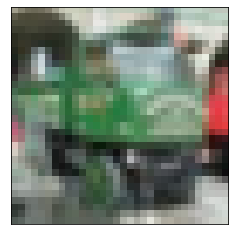

In [45]:
import random

image, label = example_dataset[random.randint(0, len(example_dataset)-1)]
print("An example of a", names[label])
show(image)

If you implemented your dataset class correctly, as well as your `build_dataset` function. You should be able to visualize random images from the dataset through the cell above. Feel free to run that cell as many times to verify that your dataset is working correctly. Now, let's instantiate a DataLoader so that we can sample batches of images from the dataset and visualize these images. Try visualizing multiple different batches. As a quick exercise, try printing out the labels of each element in the batch and verify whether it corresponds to the images correctly.

In [46]:
importlib.reload(submitted)
loader_params = {"batch_size": 4, "shuffle": True}
example_dataloader = submitted.build_dataloader(example_dataset, loader_params=loader_params)

image batch shape:  torch.Size([4, 3, 32, 32])
label batch shape:  torch.Size([4])


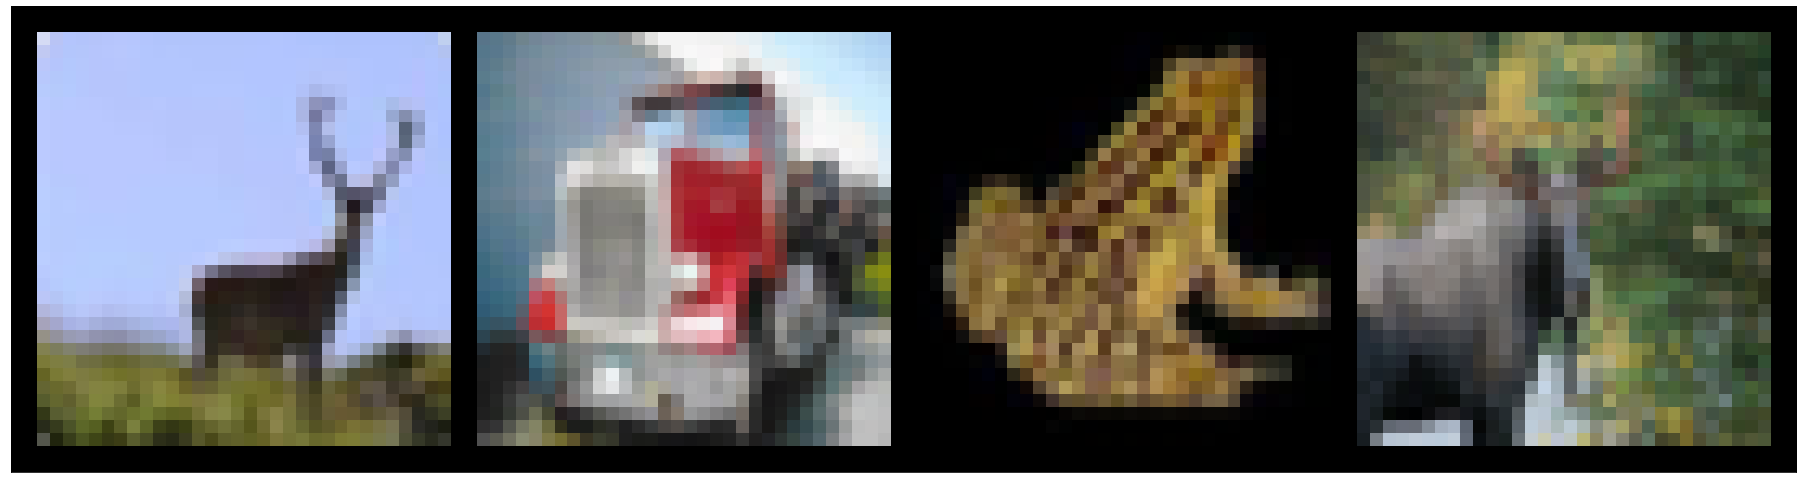

In [47]:
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

image_batch, label_batch = next(iter(example_dataloader))
print("image batch shape: ", image_batch.shape)
print("label batch shape: ", label_batch.shape)
show(make_grid([image_batch[i, :, :, :] for i in range(image_batch.shape[0])], nrows=4), figsize=(32, 32))

<a id='section3'></a>
## Model Finetuning

In this section you will create your own model based on a pretrained backbone and finetune it on the CIFAR10 dataset. 

Some useful resources:

* <a href="https://pytorch.org/tutorials/beginner/saving_loading_models.html">Saving and loading models</a> tutorial in PyTorch
* <a href="https://pytorch.org/docs/master/notes/autograd.html#locally-disabling-gradient-computation">Autograd mechanics</a> for understanding how to freeze parts of the model (go to section -- Locally disabling gradient computation)


It is highly recommended to read and understand these resources before diving into the code. Here is a short summary:


### Saving and loading models

It is a very common and useful practice to leverage pretrained models (models that have been trained for a specific task already) on other downstream tasks. There can be many reasons to do so: (1) the representations learned by a model for a different dataset/task may transfer well to our desired task, (2) we may want to train the model with less compute resources so we don't want to train the entire model, etc. Intuitively, suppose you have trained a model on the massive ImageNet dataset to recognize all kinds of different objects and you obtain relatively good performance. The features the model has learned to extract through its convolutional backbone to detect "general" objects could be very applicable to a different dataset (with different objects). In this part of the MP, you will leverage a pretrained model and finetune it on our CIFAR10 dataset. We provide a model checkpoint `resnet18.pt` in the source code, corresponding to a pretrained version of the <a href="https://pytorch.org/hub/pytorch_vision_resnet/">ResNet18</a> architecture. You will need to figure out how to load this model checkpoint and then identify which layers to use as your backbone (hint: only the final part of your network should be excluded from your backbone). 

After you load your model checkpoint, you need to also initialize new classification layers on top of the backbone. Think about what type of layers you would need for classification. Finally, you can complete your `forward` function in your network according to your logical separation of backbone/classifier. 


### Autograd mechanics

You are almost done with your implementation of your network. The final step is to ensure that your backbone parameters are frozen! This means that the weight parameters in your backbone should not receive any gradient updates during backpropagation. In essence, we are assuming the backbone will already be effective for the task at hand (so it no longer needs to be trained) and we only the train the classifier. Refer to the PyTorch tutorial for help (there are also many online resources that discuss this topic).

You are now ready to train and test your model! Fill out the `train` and `test` functions -- you should have a good reference in MP04 how to do so. Please be careful about the loss function / computation (e.g. if you use negative log likelihood loss, make sure your logits are normalized). `run_model` should orchestrate the entire training and testing flow and should call the functions you have completed so far.

Note: ResNet18 is fairly large to train on a CPU. Do not be alarmed if it takes a few minutes to train and test. Through empirical verification, you should be able to get ~90% performance after 5-7 minutes of training if done correctly. 

In [55]:
importlib.reload(submitted)
submitted.run_model()

Epoch: 1/1, Test Acc: 0.9413


FinetuneNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

<a id='grade'></a>
## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework! Before you submit it to Gradescope, try grading it on your own machine. This will run some visible test cases. Note that these visible test cases do not test the accuracy of your model, but we expect your finetuned model to achieve at least 90% accuracy on the test set to pass the hidden test cases. Make sure you test locally and can ensure that you can achieve 90% accuracy before submitting to the autograder (it may take even longer to run on the autograder).

The exclamation point (!) tells python to run the following as a shell command. Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

In [28]:
!pip3 install gradescope_utils
!python grade.py

..
----------------------------------------------------------------------
Ran 2 tests in 0.154s

OK
